# Running Image Classification on a webcam or video feed

This sample shows you how to run OpenVINO inference engine along with a webcam or video stream inside a notebook. You can see the real-time result at the bottom of this notebook. For the best result, please ensure the object of interest fills the entire screen and avoid cluttered backgrounds. Also, you may notice the algorithm may classify various thing unexpectedly, and it is indeed a good exercise for developers to understand the limitations. 

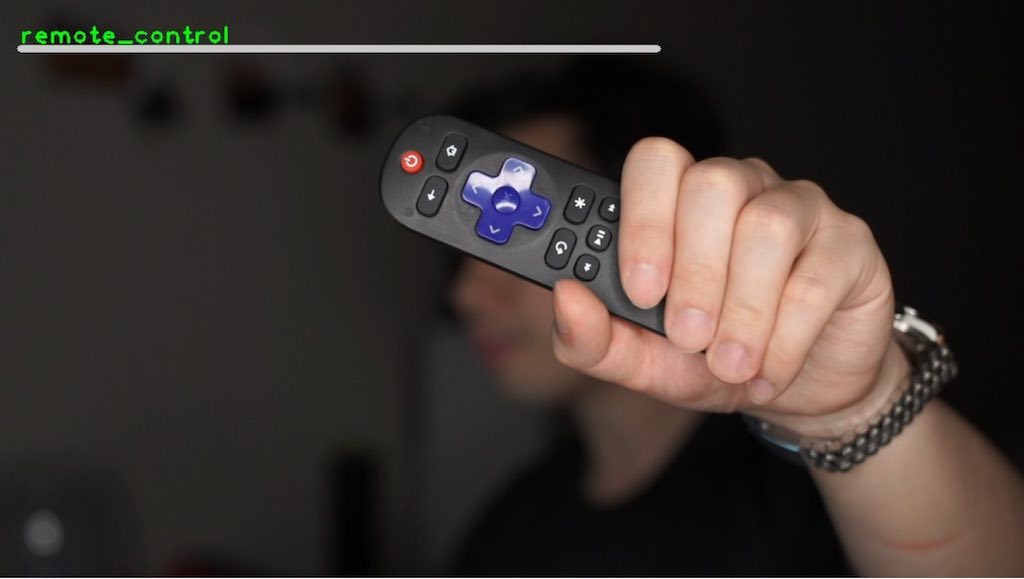

To find out more about the classification model and the number of classes it supported, please refer to the details in the 001-hello-world notebook. This model classifies 1000 classes of objects including many common objects such as remote control, cup, cat, dog; and uncommon objects such as shark, water snake, mongoose, and more. You can explore these classes by downloading the labels in the ImageNet Data (https://image-net.org/download.php) and also study the data that's used to create this neural network model.

In [ ]:
import platform

import numpy as np
import cv2

from IPython import display

import json
from openvino.inference_engine import IECore

### Helper function
This function shows the top 5 results and overlay the results on the frame.

In [ ]:
def drawResults(image, results, imagenet_classes, topK=5):
    #sort the top K results from the result
    indices = np.argsort(-results[0])
    
    #draw the class namea anda a bar to visualize the weight
    for i in range(topK):
        result_text = (imagenet_classes[indices[i]][1])
        p_length = float(results[0][indices[i]])
        y = 40*(i+1)
        x = 20
        width = image.shape[1]
        if(p_length>0.15):
            cv2.line(image, (x, y+5), (int(p_length*width), y+5),(230,230,230),3)
            #draw a shadow for the text to improve visibility - nice hack 
            cv2.putText(image, text=result_text, org=(x+1,y+1), fontFace=1, 
                fontScale=1.5, color=(0,0,0), thickness=2)
            cv2.putText(image, text=result_text, org=(x,y), fontFace=1, 
                fontScale=1.5, color=(0,255,0), thickness=2)
    return image

In [ ]:
#This function handles the video stream.
def classifyVideo(VideoIndex=0, scale=0.5):
    ie = IECore()
    net = ie.read_network(
        model="../001-hello-world/model/v3-small_224_1.0_float.xml"
    )
    exec_net = ie.load_network(net, "CPU")

    input_key = list(exec_net.input_info)[0]
    output_key = list(exec_net.outputs.keys())[0]

    imagenet_classes = json.loads(open("../001-hello-world/utils/imagenet_class_index.json").read())
    imagenet_classes = {
        int(key) + 1: value for key, value in imagenet_classes.items()
    }
    try:
        cap = cv2.VideoCapture(VideoIndex)
    except:
        print("Cannot Open Device")
        del exec_net
    try:
        ret, frame = cap.read()
        platform_system = platform.uname().system
        
        while(ret==True):
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            if not ret:
                # Release the Video Device if ret is false
                cap.release()
                # Message to be displayed after releasing the device
                print ("Released Video Resource")
                break
            
            #resize the full image down
            half_frame = cv2.resize(frame, (0, 0), fx = scale, fy = scale)
            
            # resize to MobileNet image shape
            p_frame = cv2.resize(half_frame, (224, 224), cv2.INTER_LANCZOS4)  
            #convert to RGB color space
            p_frame = cv2.cvtColor(p_frame, cv2.COLOR_BGR2RGB)
            # reshape to network input shape
            p_frame = np.expand_dims(p_frame.transpose(2, 0, 1), 0)  
            
            #run the inference
            results = exec_net.infer(inputs={input_key: p_frame})[output_key]
            
            #draw the results
            half_frame = drawResults(half_frame, results, imagenet_classes)
            
            #Workaround to use OpenCV imshow to avoid display flickering issue on Linux
            if (platform_system == 'Linux'):
                cv2.imshow("Press ESC or Q to Exit", half_frame)
                key = cv2.waitKey(1)
                if (key == ord('q') or key == 27):
                    cv2.destroyAllWindows()
                    cap.release()
                    break
            else: 
                #convert to jpg for performance results
                _,ret_array = cv2.imencode('.jpg', half_frame) 
                i = display.Image(data=ret_array)            
                display.clear_output(wait=True)
                display.display(i)
                
    except KeyboardInterrupt:
        # Release the Video Device
        cap.release()
        cv2.destroyAllWindows()
        # Message to be displayed after releasing the device
        print("Released Video Resource from KeyboardInterrupt")
        del exec_net
    pass

### Run on a Webcam

In this example, we will run the classification on the first index (e.g., 0) in the device list. 

**Warning:** Please use the stop button to close off the thread nicely. Otherwise you may need to restart the kernel to unlock the resource.

In [ ]:
#Try the webcam at index 0 and down scale to 50% for better performance
#You can switch between webcams by changing index to 1 or 2 depends on your device configuration.
classifyVideo(0, 0.75)

### Run on a Video Stream
Additionally, you can also run this on a pre-recorded video by providing the path to the video file (e.g., sample.avi). 

To learn more about what video formats are supported, you can visit the documentation below.

https://docs.opencv.org/4.5.1/dd/d43/tutorial_py_video_display.html

In [ ]:
#classifyVideo("sample.avi", 1)